# <u>Multivariate Outlier Detection in Geochemical Datasets</u>

This notebook is intended as an open-source resource for exploring, analyzing and comparing three different methods of outlier detection in geochemical datasets in the context of mineral exploration.  
<br />
<br />
The three primary outlier detection algorithms we will use are the following: 
- Isolation Forests (IF) (Liu et al., 2008)
- Local Outlier Factor (LOF) (Breunig et al., 2000)
- Angle Based Outlier Detection (ABOD) (Shahrestani & Sanislav, 2025)
<br />
<br />

This work is driven from the findings in Antoine Caté's article on multivariate outlier detection for mineral exploration.

<br />
<br />
<u>References: </u>

*Breunig, M. M., Kriegel, H.-P., Ng, R. T., and Sander, J., 2000, LOF: Identifying Density-Based Local Outliers: ACM SIGMOD Record, v. 29, no. 2, p. 93-104.*

*Liu, F. T., Ting, K. M., and Zhou, Z.-H., 2008, Isolation Forest, 2008 Eighth IEEE International Conference on Data Mining, p. 413-422.*

*Maklin, C., 2022, Isolation Forest - Cory Maklin - Medium: Medium, https://medium.com/@corymaklin/isolation-forest-799fceacdda4.*

*Shahrestani, S., and Sanislav, I., 2025, Mapping geochemical anomalies using angle-based outlier detection approach: Journal of Geochemical Exploration, v. 269.*
<br />

---

In [1]:
import pandas as pd
import geopandas as gpd

from helper_functions import plot_outlier_results, plot_scores, plot_validation, plot_roc_curves, calculate_f_score, calculate_mi_score, calculate_roc_auc
from outlier_detection_functions import isolation_forest, local_outlier_factor, abod

*For the testing of these algorithms we are going to use geochemical data from a region in southwestern Saudi Arabia. All units are converted to ppm for consistency.*

In [2]:
# Import and preview the data, create a copy of the data with only numeric columns
data_filepath = "/Users/thowe/MinersAI Dropbox/Tyler Howe/KSA Data/KSA_GSAS_data.csv"
df = pd.read_csv(data_filepath)
print(df.head(3))

feature_columns = ['Br', 'Cl', 'Cr', 'Hf',
       'P', 'Rb', 'Ti', 'Zr', 'SiO2', 'Al2O3', 'TFe2O3', 'K2O', 'Ba', 'Mn',
       'Sr', 'V', 'Zn', 'MgO', 'CaO', 'Na2O', 'Be', 'Bi', 'Co', 'Cs', 'Cu',
       'Ga', 'In', 'Li', 'Mo', 'Nb', 'Ni', 'Tl', 'Te', 'Sc', 'Y', 'Ge', 'I',
       'Ta', 'W', 'Re', 'Au', 'Ir', 'Os', 'Pd', 'Pt', 'Rh', 'Ru', 'Sb', 'Se',
       'Ag', 'B', 'Sn', 'F', 'N', 'S', 'TC', 'LOI'] # List of all geochemical columns to be used in the analysis

  Sample Field Number  Longitude   Latitude       Br      Cl     Cr       Hf  \
0         421911AD001  42.772083  19.993880  1.41950  62.743  47.29  3.49742   
1         421911AD002  42.778492  19.996819  2.13468  28.329  52.81  4.82120   
2         421911AD003  42.814612  19.982057  1.89862  31.059  35.74  5.69027   

         P      Rb        Ti  ...      Sb      Se        Ag         B  \
0  759.625  41.156  3307.385  ...  0.4220  0.2038  0.036737  16.64191   
1  828.342  45.921  4517.659  ...  0.8238  0.1229  0.045773  12.55748   
2  769.358  50.198  5789.542  ...  1.2301  0.1830  0.050043  12.21876   

         Sn      F       N      S      TC      LOI  
0  1.402524  487.1   89.39  124.6  6725.0  38100.0  
1  1.902777  442.5   86.80   62.2  4647.0  35300.0  
2  2.071384  521.3  127.60   66.3  6186.0  39100.0  

[3 rows x 60 columns]


### <u>Isolation Forest</u>

Isolation forest is an unsupervised machine learning method of outlier/anomaly detection. It is an ensemble method that combines the predictions of several decision trees to assign an anomaly score to a given data point. Samples that require fewer splits across all trees are given a lower anomaly score (higher likelihood of being anomalous). This method of outlier detection is not affected by data distribution, but does require some parameter-tuning. 

In [3]:
# Run the function
IF_df, IF_outliers = isolation_forest(
    df, feature_columns, contamination=0.1
)

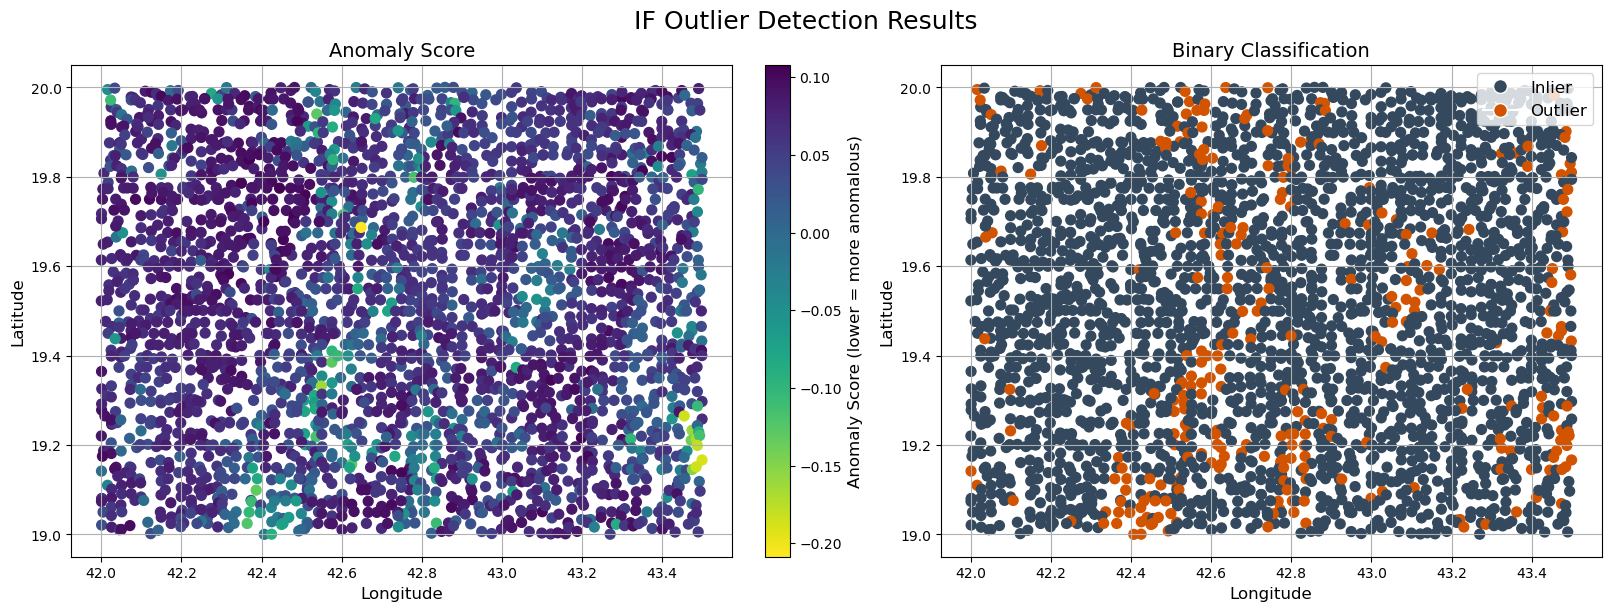

In [4]:
# Plotting IF results
plot_outlier_results(
    data=IF_df,
    x_col="Longitude",
    y_col="Latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="IF Outlier Detection Results",
    cmap='viridis_r'
)

Remember that lower anomaly scores for IF indicate a *higher likelihood of being anomalous.*
<br /> 
<br /> 


---

### <u>Local Outlier Factor</u>

LOF is another unsupervised outlier detection method that uses a density-based approach, comparing the density of data points in their local neighborhoods. Isolated samples or those on the margins of a neighborhood cluster will have a lower density than their neighbors. Samples with a lower LOF value are considered outliers. Similar to IF, LOF is unaffected by data distribution but does require some parameter-tuning.

In [5]:
LOF_df, LOF_outliers = local_outlier_factor(
    df, feature_columns, contamination=0.1, n_neighbors=50, scale_data=False
)

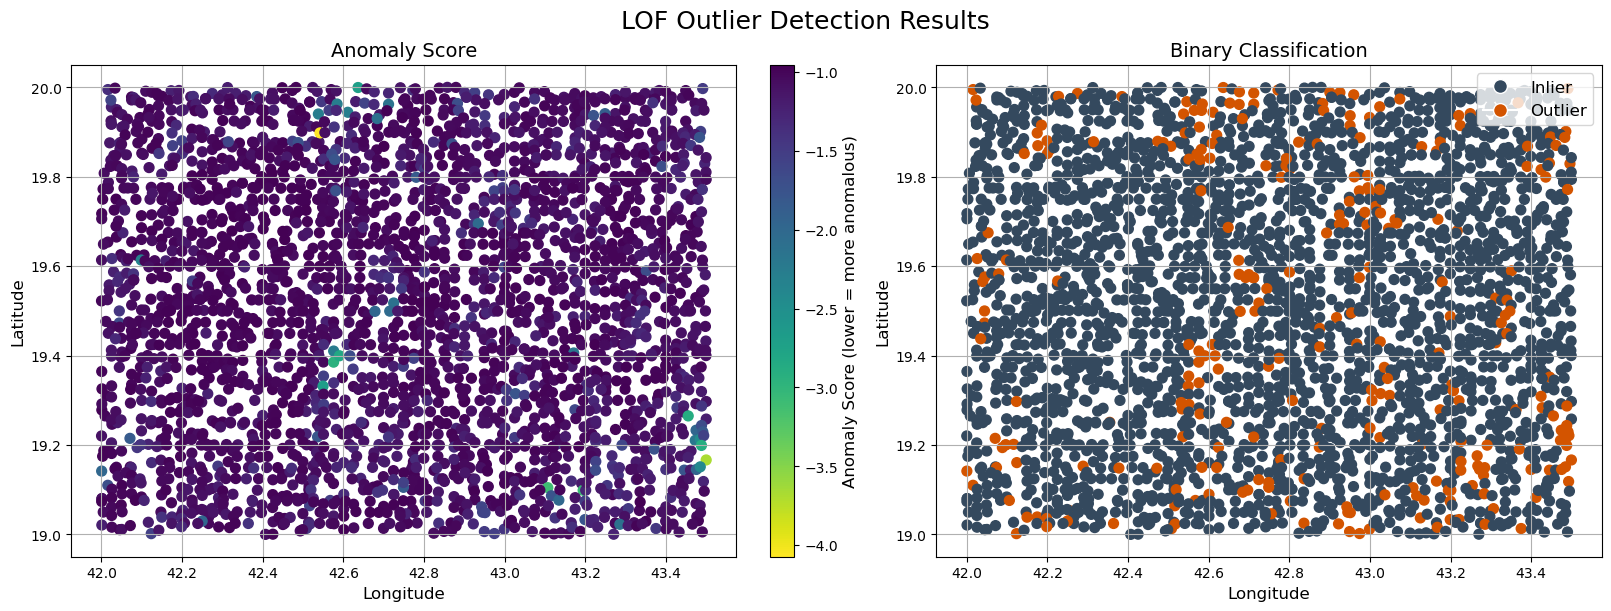

In [6]:
# Plotting LOF results
plot_outlier_results(
    data=LOF_df,
    x_col="Longitude",
    y_col="Latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="LOF Outlier Detection Results",
    cmap="viridis_r",
)


---

### <u>Angle Based Outlier Detection</u>

Our final method of outlier detection is angle based outlier detection. This method compares the distribution of angles of distance vectors between a sample point and its neighbors; a point with a large distribution of vector angles is considered an inlier (within a cluster), while a point with a smaller distribution of angles is likely an outlier (outside a cluster). An angle-based score is then calculated, with less variation indicating a higher probability of the sample point being an outlier. One benefit of ABOD is that it is free of any parameters, and thus does not have the potential prediction variability resulting from tuning. Its implementation does not, however, output a binary classification, thus in order to generate one an arbitrary threshold must be defined. 

In [7]:
ABOD_df= abod(
    df, feature_columns, scale_data=True
)

In [8]:
# Define the threshold (manually or based on a percentile)
threshold = ABOD_df["anomaly_score"].quantile(0.05)  # Bottom 5% of anomaly scores

# Add a binary 'outlier' column based on the threshold
ABOD_df["outlier"] = ABOD_df["anomaly_score"].apply(
    lambda x: -1 if x < threshold else 1
)

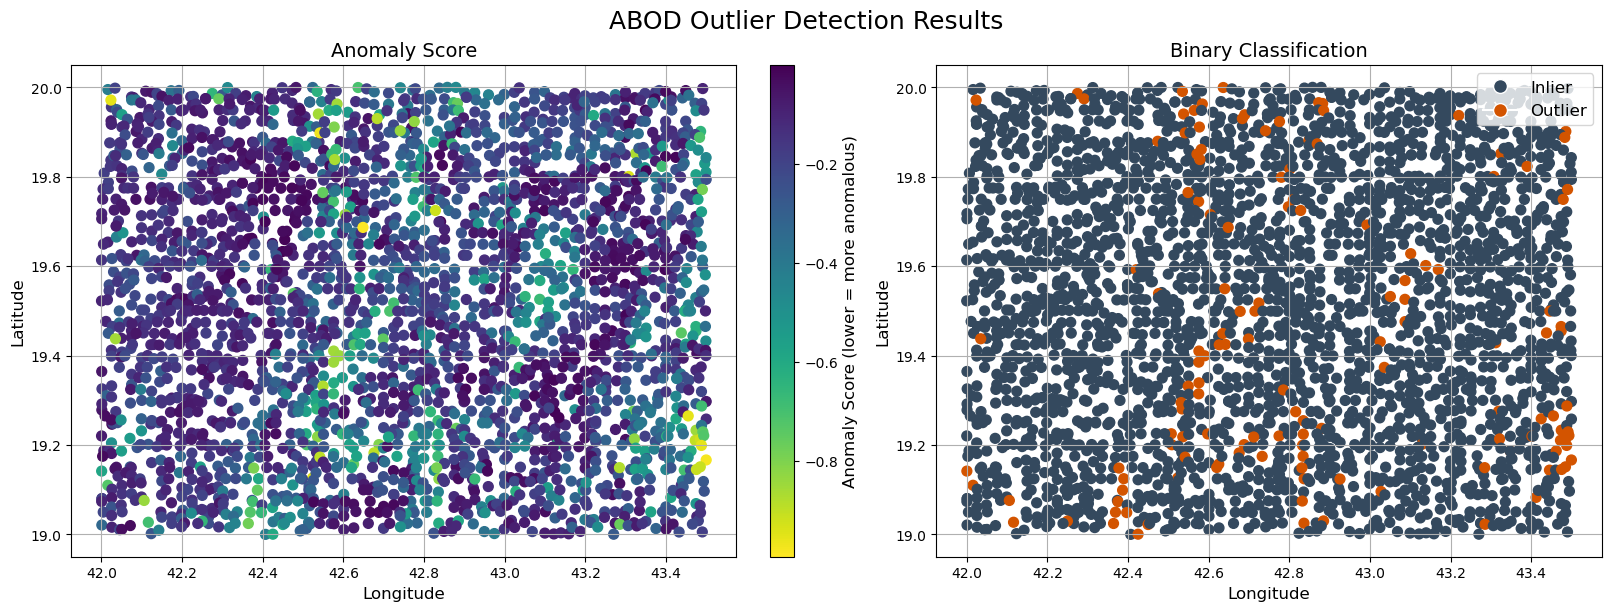

In [9]:
# Plotting LOF results
plot_outlier_results(
    data=ABOD_df,
    x_col="Longitude",
    y_col="Latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="ABOD Outlier Detection Results",
    cmap="viridis_r",
)

---

## <u>Validation of predictions</u>

Multivariate anomaly detection picks up on trends across multiple elements, rather than just single-element variation. As opposed to univariate anomalies that may be attributed to noise, sampling error, or highly-localized trends, multivariate analysis may point towards regions of broader geologic alteration related to mineral deposits. To test this relationship, we will compare outlier predictions from each model against known mineral occurrences in the sampling region. 

In [10]:
# Import validation dataset

validation_filepath = "/Users/thowe/MinersAI Dropbox/Tyler Howe/KSA Data/KSA_gsas_mineral_occurrences_clipped.geojson"

validation_gdf = gpd.read_file(validation_filepath)
validation_df = validation_gdf.copy()
validation_df['Longitude'] = validation_df['geometry'].x
validation_df['Latitude'] = validation_df['geometry'].y
validation_df.drop(columns='geometry', inplace=True)

### *Spatial validation of outlier predictions*

To start, we will conduct a visual analysis on the data, comparing binary outlier classifications vs. known mineral occurrences in the region.

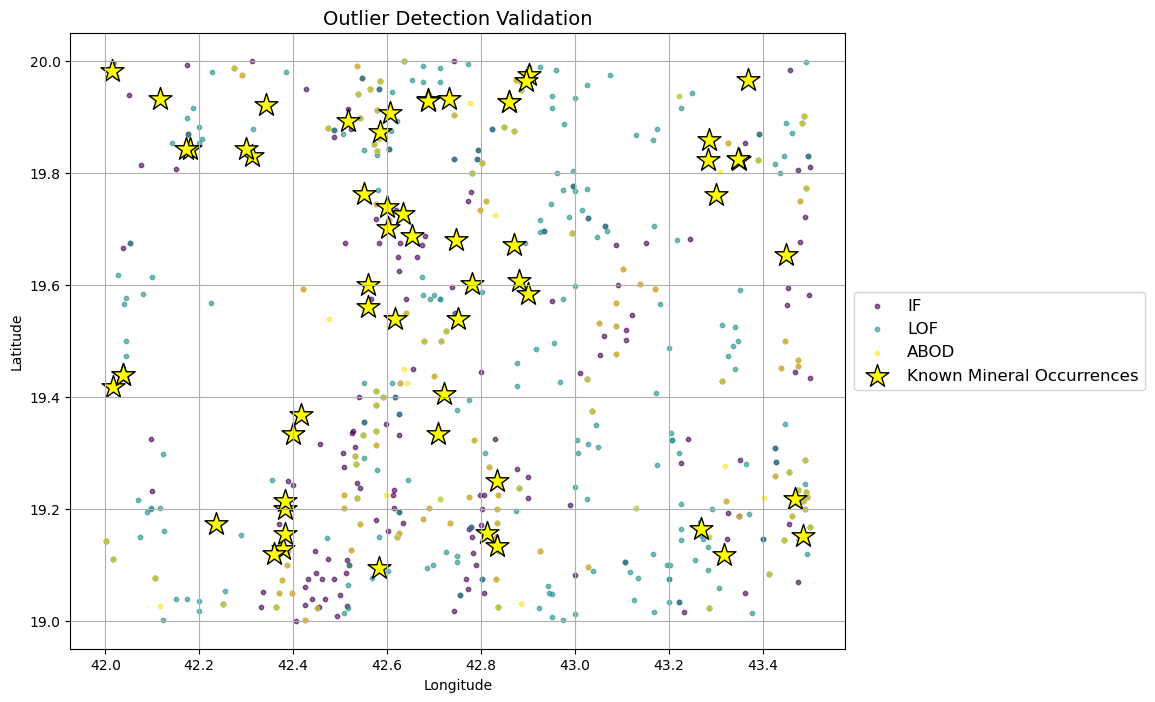

In [11]:
# Plot outlier detection results and validation dataset

outlier_results = [IF_df, LOF_df, ABOD_df]
outlier_result_names = ['IF', 'LOF', 'ABOD']

plot_validation(outlier_datasets=outlier_results, outlier_dataset_names=outlier_result_names, validation_df=validation_df, point_size=10, colormap='viridis')

---

### *ROC-AUC, ANOVA F-statistic, and Mutual Information scoring of outlier predictions*

To quantitatively compare the different outlier prediction methods, we will use three different scoring methods: ROC-AUC, ANOVA F-statistic, and Mutual Information.
<br />
<br />
- *<u>ROC-AUC, or Receiver Operating Characteristic Area Under the Curve</u>* is a machine learning metric used to evaluate a model's ability to distinguish between positive and negative classes; a score of 1 is considered 'perfect,' or that the model gets 100% of predictions correct. 
    - Generally best for evaluating overall predictive performance, regardless of spatial location.
<br />
<br />
- The *<u>ANOVA F-statistic</u>* is a method of comparing the variances of two samples (in this case the prediction and the validation set); the higher the score, the greater the model's predictions are differentiated. That is, there is a meaningful pattern between predicted outliers and known mineral deposits.
    - Measures how well the model distinguishes spatially relevant anomalies.
<br />
<br />
- *<u>Mutual Information</u>* is a method of measuring how much information one variable provides about another, or how dependent they are on each other. Higher MI values indicate stronger relationships between variables. 
    - Quantifies dependency between outlier predictions and proximity to known deposits.

ROC-AUC Score for IF: 0.6980
ROC-AUC Score for LOF: 0.6475
ROC-AUC Score for ABOD: 0.7579
F-Score for IF: 30.6217
F-Score for LOF: 10.8421
F-Score for ABOD: 35.8927
Mutual Information Score for IF: 0.0019
Mutual Information Score for LOF: 0.0008
Mutual Information Score for ABOD: 0.0026


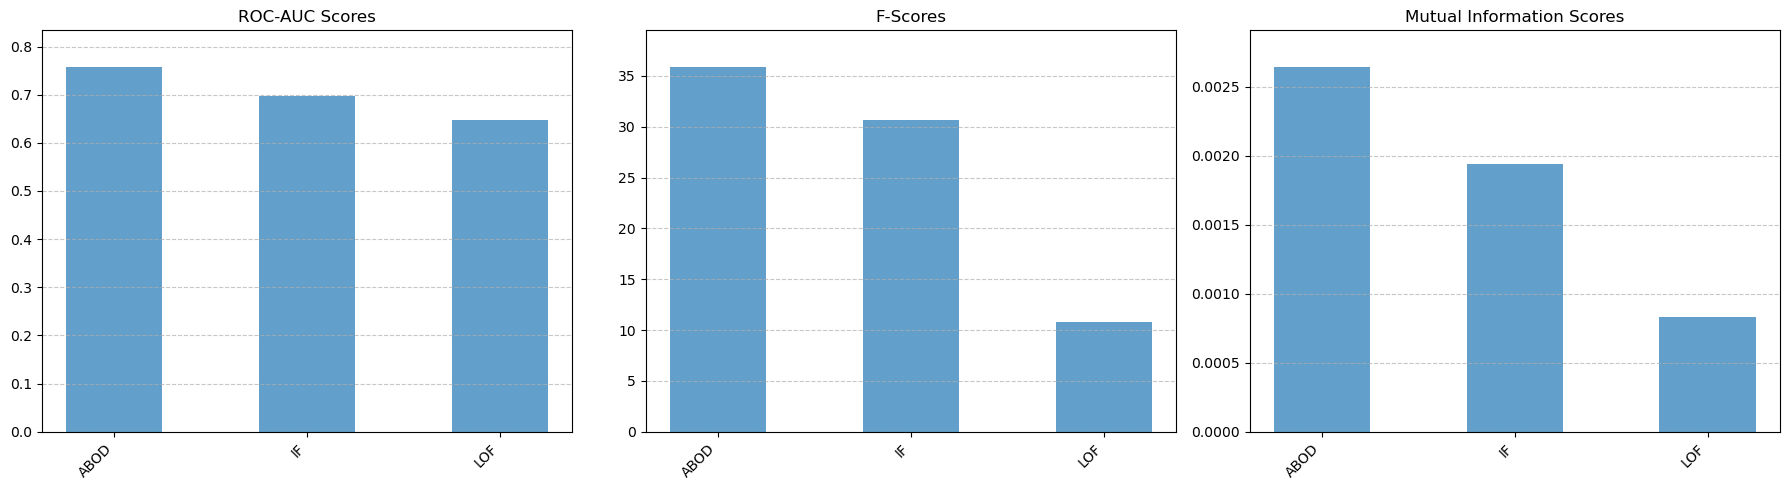

In [12]:
# Calculate scores for each outlier detection method
# rad 0.005 ~=500m

scoring_radius = 0.005 # roughly 500m

roc_auc_scores = calculate_roc_auc(
    outlier_results, outlier_result_names, validation_df, radius=scoring_radius
) 

f_scores = calculate_f_score(
    outlier_results, outlier_result_names, validation_df, radius=scoring_radius
)

mi_scores = calculate_mi_score(
    outlier_results, outlier_result_names, validation_df, radius=scoring_radius
)

plot_scores([roc_auc_scores, f_scores, mi_scores], titles=["ROC-AUC Scores", "F-Scores", "Mutual Information Scores"])

---

### *Deeper investigation into ROC-AUC scoring of each model*

Since the ROC-AUC scores for each model above are so similar, let's create a ROC curve to better understand the model performance. 

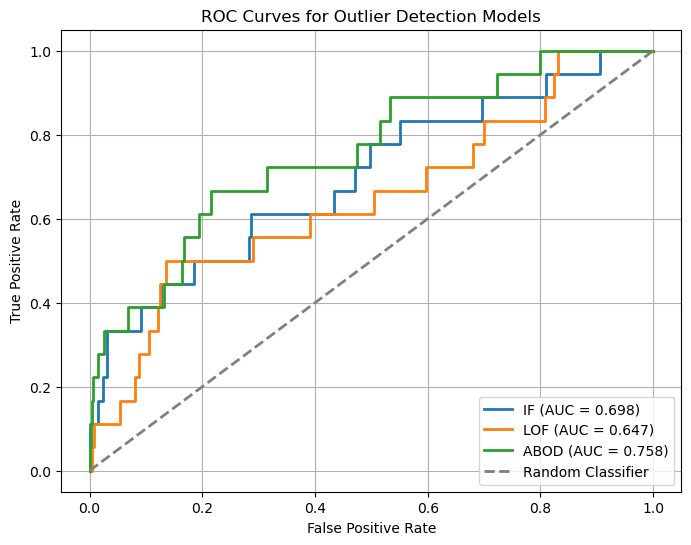

In [13]:
plot_roc_curves(
    outlier_datasets=outlier_results,  # Your outlier model DataFrames
    outlier_dataset_names=outlier_result_names,  # Names of models
    validation_df=validation_df,  # Known mineral deposits
    radius=scoring_radius,  # Search radius
)

The ROC curve above matches the results we observed - the ABOD method appears to best optimize the TPR/FPR ratio, indicating better model performance. 

It is also important to consider, however, the time cost of each model; IF and LOF process almost instantly, while ABOD takes some time due to the nature of the calculation. Optimized versions of the ABOD, such as FastABOD, exist, though they utilize methods such as k-nearest neighbors to calculate variance rather than using all possible pairs in the dataset, potentially skewing results. For relatively small datasets, the time cost of ABOD is minimal, but for larger datasets the tradeoffs should be considered; it may be more efficient to use an algorithm like Isolation Forest despite the small cost in model accuracy.